# Podcast Editing pt1 - Removing Silence
I will first try to detect and remove periods of silence based on a noise window. 

In [2]:
from a3py import *
import scipy as sp

### Let's grab some audio...


Input Audio File ./media/diggy_silences_short.wav:


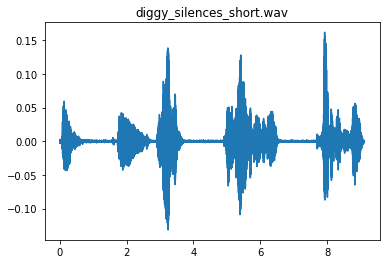

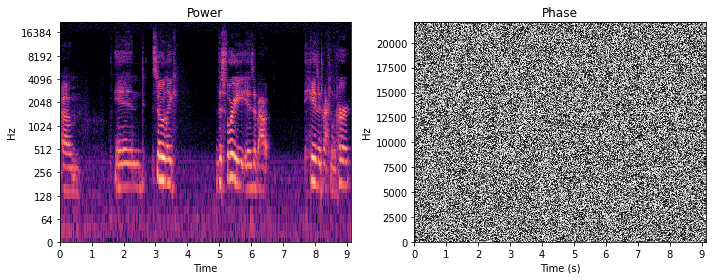

In [2]:
audio_file_path = './media/diggy_silences_short.wav';

a = Audio(audio_file_path);
print("Input Audio File {}:".format(audio_file_path));
a.play()
a.plot();
stft = STFT.FromAudio(a);
stft.show()

<class 'a3py.Audio.Audio'>


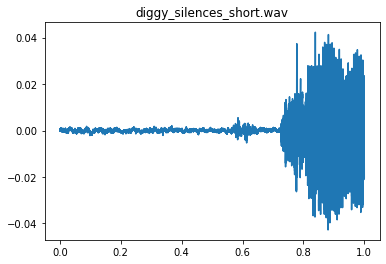

In [3]:
print(type(a));
# a.samples = a.samples[0];
# a.plot();
b = a.GetClip(1, 2);
b.plot();

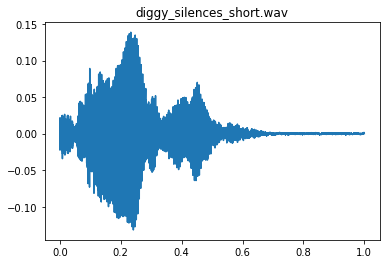

In [4]:
c = a.GetClip(3, 4);
c.plot();

In [5]:

# np.concatenate(b.samples, c.samples, 0);
# samples = a.samples;
# rate = a.sampling_rate;
# audio_out_path = './media/testout.wav';
# newAud = a;
# newAud._initSamples(samples, rate);
# newAud.play();
# newAud = Audio(audio_out_path, a.sampling_rate, samples);
# newAud.plot();

#... This aint working, time for a new approach.

# Podcast Editing pt2 - Pydub
I found that a3py didnt offer what i needed in terms of slicing (as least i couldnt quite figure it out), so trying pydub instead.

In [3]:
from pydub import AudioSegment
from pydub.playback import play

### Let's grab some audio...

In [4]:
audio_file_path = './media/diggy_silences_short.wav';
pod = AudioSegment.from_wav(audio_file_path);

In [5]:
#Play the audio
play(pod);

In [6]:
#I couldnt find an easy way to display waveforms in pydub
#so here's a happy litte function using a3py instead
def displayWaveform(song):
    temppath = "media/temp.wav";
    song.export(temppath, format="wav")
    a = Audio(temppath);
    a.plot();
    a.play();

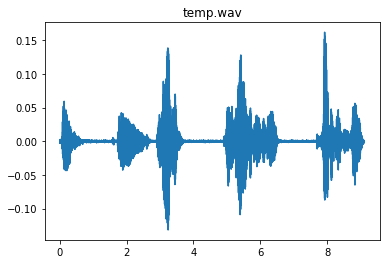

In [7]:
#Example
displayWaveform(pod);

Now to slice using pydub

In [8]:
from pydub import AudioSegment, silence

In [12]:
#Temporary values
min_silence_length_ms = 100;
silence_threshold_db = -40;
seeking_step_ms = 5;

speaking_segments = silence.detect_nonsilent(pod, min_silence_length_ms, silence_threshold_db, seeking_step_ms);
print(speaking_segments);
# print(type(speaking_segments));

[[140, 270], [1840, 2190], [3065, 3475], [5020, 5135], [5275, 5710], [5895, 5950], [6300, 6385], [7905, 8145], [8785, 8950]]


In [13]:
def combine_segments(audio, segs, padding = 100, cross = 100):
    if len(segs) <= 0:
        return audio[0:0]
    
    retval = AudioSegment.silent(duration=padding);
    silence_pad = AudioSegment.silent(duration=padding)
    
    for seg in segs[0:]:
        start = seg[0];
        end = seg[1];
        
        clip = audio[start:end];
        paddedClip = clip.append(silence_pad, crossfade=0);
        retval = retval.append(paddedClip, crossfade=cross);

    return retval

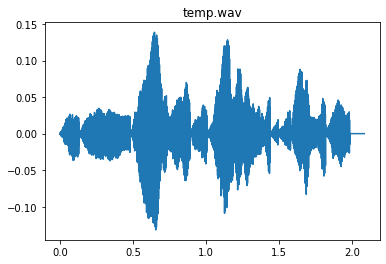

In [14]:
edited_pod = combine_segments(pod, speaking_segments);
displayWaveform(edited_pod);

It cuts and splices correctly, but it seems like the silence detection is off.
To fix this we will take a segment that we know to be silence (noise) and take the maximum db from it, then use that when 

In [15]:
noiseRange_ms = [700,1500];
noiseClip = pod[noiseRange_ms[0]:noiseRange_ms[1]];
noiseDB = noiseClip.dBFS;
print(noiseClip.dBFS);

-64.73392668013777


[[0, 645], [795, 925], [1580, 1620], [1725, 2670], [2910, 3680], [4905, 6570], [7690, 9117]]


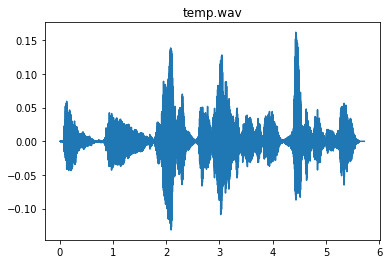

In [16]:
#Reset Values
min_silence_length_ms = 100;
silence_threshold_db = noiseDB; #Set barried to silence DB
seeking_step_ms = 5;

speaking_segments = silence.detect_nonsilent(pod, min_silence_length_ms, silence_threshold_db, seeking_step_ms);
print(speaking_segments);

edited_pod = combine_segments(pod, speaking_segments);
displayWaveform(edited_pod);

That works pretty well - For now I will clean all of this up and put it into a function. 

In [14]:
def Audio_RemoveSilences(track, noiseStart, noiseEnd, min_silence_len = 100, seeking_step = 20, padding = 100, crossfade = 100):
    noiseClip = track[noiseStart:noiseEnd];
    noiseDB_threshold = noiseClip.dBFS;
    speaking_segments = silence.detect_nonsilent(track, min_silence_len, noiseDB_threshold, seeking_step);
    edited_track = combine_segments(track, speaking_segments, padding, crossfade);    
    return edited_track;

In [15]:
def File_RemoveSilences(in_path, out_path, noiseStart, noiseEnd):
    track = AudioSegment.from_wav(in_path);
    result = Audio_RemoveSilences(track, noiseStart, noiseEnd);
    result.export(out_path, format="wav")
    displayWaveform(result);

Lets give it a spin:

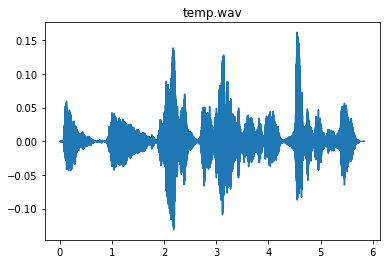

In [19]:
pod_silences_short_path = './media/diggy_silences_short.wav';
pod_silences_short_path_out = './media/diggy_silences_short_EDITED.wav';
File_RemoveSilences(pod_silences_short_path, pod_silences_short_path_out, 700, 1500);

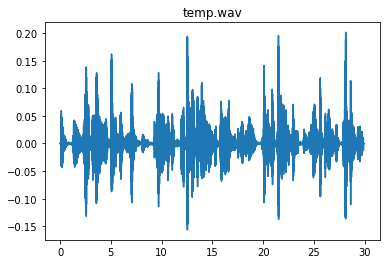

In [16]:
pod_diggytest = './media/diggy_silences.wav';
pod_diggytest_out = './media/diggy_silences_EDITED.wav';
noiseStart = 3*1000 + 740;
noiseEnd = 4*1000 + 740;
File_RemoveSilences(pod_diggytest, pod_diggytest_out, noiseStart, noiseEnd);

Lets try it on a full podcast

In [17]:
pod_ep3 = './media/pod_ep3_full.wav';
pod_ep3_out = './media/pod_ep3_full_EDITED.wav';
noiseStart = 220*1000 + 787;
noiseEnd = 221*1000 + 89;
# File_RemoveSilences(pod_ep3, pod_ep3_out, noiseStart, noiseEnd);

# a = Audio(pod_ep3_out);
# a.plot();
# a.play();

This took an episode from 45minutes 45 seconds to 36 minutes 25 seconds. It took a few minutes to process, but compared to an hour or so by hand it is definitely a success.